In [1]:
from keras.engine import Model
from keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization, Activation
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils
from keras.optimizers import Adam
from keras.preprocessing import image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from sklearn.utils import class_weight
import keras
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/gloria/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/gloria/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Constants
IMG_SIZE = 224

IMG_DIR = '../project/eval_data/all_females_train_s'
RATING_PATH = '../project/eval_data/all_females_train_s/train_ratings.txt'

TEST_IMG_DIR = '../project/eval_data/all_females_test_s'
TEST_RATING_PATH = '../project/eval_data/all_females_test_s/test_ratings.txt'

VERSION = 'eval-Clas-10k'

In [3]:
def getMean(train_data):
    #calculate mean values for pixels (RGB)

    data = np.zeros((train_data.shape[0], IMG_SIZE, IMG_SIZE, 3)) 
    for i in range(train_data.shape[0]):
        _img = image.load_img(os.path.join(IMG_DIR, train_data[i]), target_size=(IMG_SIZE,IMG_SIZE))
        data[i,:,:,:] = image.img_to_array(_img)
    mean = np.mean(data, axis=(0, 1, 2))
    print("Pixel means: ",mean)

    return mean

In [4]:
def preprocess(x,mean):
    x[:,:,0] -= mean[0]
    x[:,:,1] -= mean[1]
    x[:,:,2] -= mean[2]

In [5]:
def prepareDataRegression(percentage):
    # Read in ratings
    ratings = np.genfromtxt(RATING_PATH)
        
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))
    #remove train_ratings.txt from images
    images.remove('train_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)

    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    

    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0

    mean = getMean(images[train_ind])
    
    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = utils.preprocess_input(_x, version=1)#preprocess(_x,mean)# / .255
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = utils.preprocess_input(_x, version=1)#preprocess(_x,mean)# / .255
            last_set_train += 1
    
    return data_train, ratings[train_ind], data_test, ratings[test_ind], ratings, mean

In [6]:
def prepareDataClassification(percentage):
    # Read in ratings
    ratings = np.genfromtxt(RATING_PATH)
    
    # Round (obviously imbalanced sets)
    ratings_rounded = np.round(ratings, 0).astype(np.int8)
    ratings = to_categorical(ratings_rounded, num_classes=len(np.unique(ratings_rounded)))
    
                
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))
    #remove train_ratings.txt from images
    images.remove('train_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)

    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    
    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0

    mean = getMean(images[train_ind])
    
    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = utils.preprocess_input(_x, version=1)#preprocess(_x,mean)# / .255
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = utils.preprocess_input(_x, version=1)#preprocess(_x,mean)# / .255
            last_set_train += 1
    
    return data_train, ratings[train_ind], data_test, ratings[test_ind], ratings_rounded, mean
    #return ratings[train_ind], train_ind, ratings[test_ind], test_ind, ratings, images

In [7]:
def prepareDataOrdinalRegression(percentage):
    # Load ratings
    ratings = np.genfromtxt(RATING_PATH)
    
    # Convert ratings to the desired format
    # 1. First round them
    ratings_rounded = np.round(ratings, 1).astype(np.int8)

    # 2. Then encode as suggested by Cheng (2007)
    ratings_prepared = np.zeros((len(ratings_rounded), len(np.unique(ratings_rounded))))
    for i, r in enumerate(ratings_rounded):
        for j in range(r):
            ratings_prepared[i, j] = 1
        
    # 3. Finally, make sure assignment is correct
    assert np.all(np.sum(ratings_prepared, axis=1).astype(np.int8) == ratings_rounded)
    
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))
    #remove train_ratings.txt from images
    images.remove('train_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    print(len(ratings))
    print(len(images))
    assert len(ratings) == len(images)
    
    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    
    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0

    mean = getMean(images[train_ind])
    
    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = preprocess(_x,mean)#utils.preprocess_input(_x, version=1)# / .255
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = preprocess(_x,mean)#utils.preprocess_input(_x, version=1)# / .255
            last_set_train += 1
    
    
    return data_train, ratings_prepared[train_ind], data_test, ratings_prepared[test_ind], ratings_rounded, mean

In [8]:
def getGenerator(data_train, data_test):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest'
                                      )#preprocessing_function=utils.preprocess_input)

    train_datagen.fit(data_train)
    
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen.fit(data_test)

    return train_datagen, test_datagen

In [9]:
def visualize_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'bo-', label="Training loss")
    plt.plot(epochs, val_loss, 'b', label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
def visualize_acc(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'ro-', label="Training acc")
    plt.plot(epochs, val_loss, 'r', label="Validation acc")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

In [11]:
def recommend(images, pred_classes):
    images = images.tolist()
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        img = mpimg.imread(os.path.join(IMG_DIR, images[i]))
        imgplot = plt.imshow(img)
        plt.show()
        plt.clf()

def recommendTest(images, pred_classes):
    images = images.tolist()
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        img = mpimg.imread(os.path.join(TEST_IMG_DIR, images[i]))
        imgplot = plt.imshow(img)
        plt.show()
        plt.clf()

### Get data

In [12]:
x_train, y_train, x_val, y_val, ratings, mean = prepareDataClassification(5)
train_generator, test_generator = getGenerator(x_train,x_val)

train_inst = x_train.shape[0]
print("x_train: ",x_train.shape)
print("y_train: ",y_train.shape)
print("x_val: ",x_val.shape)
print("y_val: ",y_val.shape)
print("ratings",ratings.shape)


Pixel means:  [173.42206268 142.60436977 128.27178817]
x_train:  (506, 224, 224, 3)
y_train:  (506, 6)
x_val:  (26, 224, 224, 3)
y_val:  (26, 6)
ratings (532,)


### Build keras model

In [13]:
# Add custom layers
vgg_base = VGGFace(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')
last_layer = vgg_base.get_layer('global_max_pooling2d_1').output
X = Dense(256, activation=None, name='fc6')(last_layer)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
X = Dense(128, activation=None, name='fc7')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
X = Dense(64, activation=None, name='fc8')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
X = Dense(len(np.unique(ratings)), activation=None)(X)
#X = BatchNormalization()(X)
output = Activation('softmax')(X)
model = Model(inputs=vgg_base.input, outputs=output)

# Freeze vgg layers
for layer in vgg_base.layers:
    layer.trainable = False

# Compute class weights since we have unbalaned classes
class_weight = class_weight.compute_class_weight('balanced', 
                                                 np.unique(ratings), 
                                                 ratings)

print(class_weight)

model.compile(optimizer=Adam(lr= 0.0005,clipnorm=1.0),
              #loss='categorical_crossentropy', 
              #metrics=['accuracy'])
              loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./weights-' + VERSION + '.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

[ 0.9047619   0.54396728  0.75141243  1.16666667  1.21461187 22.16666667]


In [14]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=train_inst//32,
    epochs=500,
    class_weight=class_weight,
    validation_data=test_generator.flow(x_val, y_val, batch_size=32),
    callbacks=[earlystop, checkpointer]
)

Epoch 1/500
15/15 [==============================] - 12s 772ms/step - loss: 2.0432 - acc: 0.1936 - val_loss: 1.9958 - val_acc: 0.2692

Epoch 00001: val_loss improved from inf to 1.99576, saving model to ./weights-eval-Clas-10k.hdf5
Epoch 2/500
15/15 [==============================] - 6s 414ms/step - loss: 1.9244 - acc: 0.2276 - val_loss: 1.9842 - val_acc: 0.1923

Epoch 00002: val_loss improved from 1.99576 to 1.98420, saving model to ./weights-eval-Clas-10k.hdf5
Epoch 3/500
15/15 [==============================] - 6s 414ms/step - loss: 1.8122 - acc: 0.2617 - val_loss: 2.0591 - val_acc: 0.2308

Epoch 00003: val_loss did not improve
Epoch 4/500
15/15 [==============================] - 6s 413ms/step - loss: 1.7561 - acc: 0.2906 - val_loss: 1.9908 - val_acc: 0.2308

Epoch 00004: val_loss did not improve
Epoch 5/500
15/15 [==============================] - 6s 413ms/step - loss: 1.6452 - acc: 0.3196 - val_loss: 1.9068 - val_acc: 0.1538

Epoch 00005: val_loss improved from 1.98420 to 1.90676,

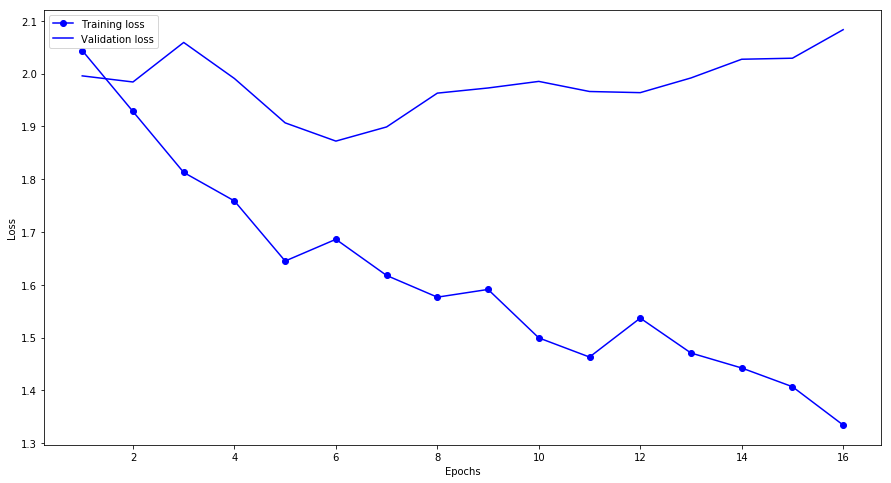

In [15]:
visualize_loss(history)

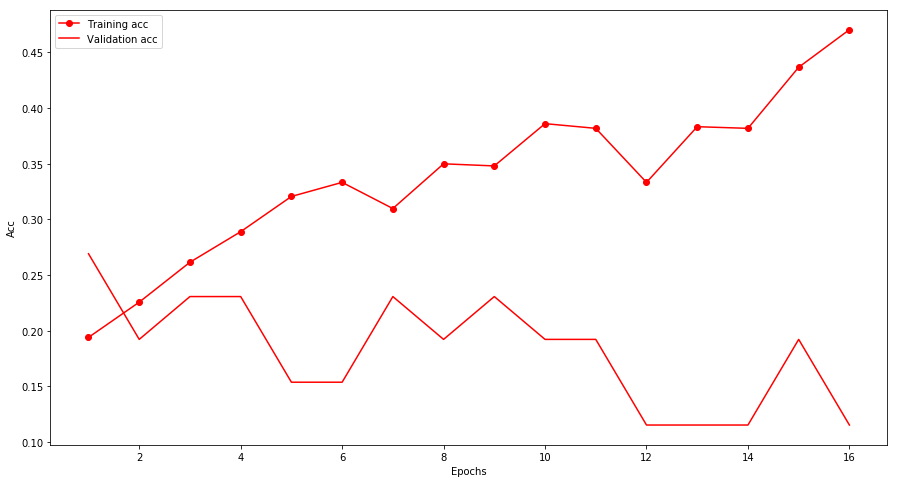

In [16]:
visualize_acc(history)

In [17]:
model.save('./models/love_classifier' + VERSION + '.h5')

### Predictions: Validation set

In [18]:
predictions = model.predict(x_val)
pred_classes = predictions.argmax(axis=-1)
pred_classes = np.round(pred_classes, 1).astype(np.int8)

y_true = np.array(y_val).argmax(axis=-1).astype(np.int8)
print(y_true)
print(pred_classes)

confusion_matrix(y_true,pred_classes)

[3 1 0 1 1 4 3 3 0 4 3 4 0 0 4 4 1 5 2 0 0 1 2 0 3 1]
[1 0 1 0 1 1 1 1 2 0 0 2 1 0 0 0 1 1 0 2 1 1 1 0 1 0]


array([[2, 3, 2, 0, 0, 0],
       [3, 3, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [1, 4, 0, 0, 0, 0],
       [3, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [19]:
recommend(x_val,pred_classes)

### Prediction: Test set

In [20]:
def prepareTestDataClassification():
    # Read in ratings
    ratings = np.genfromtxt(TEST_RATING_PATH)
    
    # Round (obviously imbalanced sets)
    ratings_rounded = np.round(ratings, 0).astype(np.int8)
    ratings = to_categorical(ratings_rounded, num_classes=len(np.unique(ratings_rounded)))
    
                
    ### Move all images according to ratings
    images = sorted(os.listdir(TEST_IMG_DIR))
    #remove test_ratings.txt from images
    images.remove('test_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)

    data = np.zeros((len(images), IMG_SIZE, IMG_SIZE, 3)) 
    last_set = 0
    
    for idx, _im in enumerate(images): #iterate over images
        _img = image.load_img(os.path.join(TEST_IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
        _x = image.img_to_array(_img)
        _x = np.expand_dims(_x, axis=0)
        data[last_set, :, :, :] = utils.preprocess_input(_x, version=1)#preprocess(_x,mean) # / .255
        last_set += 1
    
    return data, ratings

In [21]:
def prepareTestDataOrdinalRegression():
    # Load ratings
    ratings = np.genfromtxt(TEST_RATING_PATH)
    
    # Convert ratings to the desired format
    # 1. First round them
    ratings_rounded = np.round(ratings, 1).astype(np.int8)

    # 2. Then encode as suggested by Cheng (2007)
    ratings_prepared = np.zeros((len(ratings_rounded), len(np.unique(ratings_rounded))))
    for i, r in enumerate(ratings_rounded):
        for j in range(r):
            ratings_prepared[i, j] = 1
        
    # 3. Finally, make sure assignment is correct
    assert np.all(np.sum(ratings_prepared, axis=1).astype(np.int8) == ratings_rounded)
    
    ### Move all images according to ratings
    images = sorted(os.listdir(TEST_IMG_DIR))
    #remove test_ratings.txt from images
    images.remove('test_ratings.txt')

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)
    
    data = np.zeros((len(images), IMG_SIZE, IMG_SIZE, 3)) 
    last_set = 0
    
    for idx, _im in enumerate(images): #iterate over images
        _img = image.load_img(os.path.join(TEST_IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
        _x = image.img_to_array(_img)
        _x = np.expand_dims(_x, axis=0)
        data[last_set, :, :, :] = utils.preprocess_input(_x, version=1)#preprocess(_x,mean) # / .255
        last_set += 1
    
    return data, ratings

In [22]:
x_test, ratings_test = prepareTestDataClassification()

predictions = model.predict(x_test)
pred_classes = predictions.argmax(axis=-1)
pred_classes = np.round(pred_classes, 1).astype(np.int8)

y_true = np.array(ratings_test).argmax(axis=-1).astype(np.int8)
print(y_true)
print(pred_classes)

confusion_matrix(y_true,pred_classes)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 2 0 0 0 1 1 1 1 1 1 2 1 0 0 0 0]


array([[0, 7, 0, 0, 0, 0],
       [0, 7, 0, 0, 0, 0],
       [3, 3, 1, 0, 0, 0],
       [3, 4, 0, 0, 0, 0],
       [3, 3, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [23]:
recommendTest(x_test,pred_classes)